## 1. Imports

In [166]:
#database
import pandas.io.sql         as psql
import psycopg2
#basic
import pandas                as pd
import numpy                 as np

#chart plot
from   pandas.plotting       import scatter_matrix
import matplotlib.pyplot     as     plt
import matplotlib.gridspec   as     gridspec
import seaborn               as     sns

#model imports
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics         import roc_auc_score

#encodings
from sklearn.preprocessing   import OneHotEncoder, LabelEncoder

#display
from IPython.display         import Image
from IPython.display         import display

import warnings

## 2. Help functions / settings

### 2.1 Settings

In [2]:
#Credentials
pgHOST = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
pgPORT = '5432'
database = 'comunidadedsdb'
user ='member'
password = 'cdspa'

In [3]:
#warings ignore
warnings.filterwarnings('ignore')

In [24]:
#Seaborn Settings
sns.set( rc={'figure.figsize': (40,10 )} )

### 2.2 Functions

In [179]:
#get data in DB
def get_data(query):
    myConnection = psycopg2.connect( host = pgHOST, user=user, password=password, dbname=database )
    df = pd.read_sql( query, myConnection)
    myConnection.close()
    return df
#data cleaning
def dt_cleaning(df):
    #cleaning up duplicate columns
    df['ident'] = df.iloc[0:,0]
    df.drop(columns='id', inplace=True)
    df.rename(columns={'ident':'id'}, inplace=True)
    #reordering columns
    df = df[[
        'id','gender', 'age', 'region_code', 'policy_sales_channel',
        'previously_insured', 'annual_premium', 'vintage', 'driving_license', 
        'vehicle_age', 'vehicle_damage', 'response'
    ]]
    return df


#split train test stratified
def stratified_split (df , feature):    
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=11)

    for train_index, test_index in split.split( df, df[feature] ):
        train_set = df.loc[train_index].reset_index(drop=True)
        test_set = df.loc[test_index].reset_index(drop=True)
    return train_set, test_set    

#One Hot Encoding
def data_hotencoding(df, column):
    ohe       = OneHotEncoder()
    g         = ohe.fit_transform( df[column].values.reshape(-1,1) ).toarray()
    df_ohe    = pd.DataFrame( g, columns=[ str( column ) + '_' + str( int( i ) ) for i in range( g.shape[1] ) ] )
    df = pd.concat( [df, df_ohe], axis= 1 )
    df = df.drop(columns=[column])
    
    return df    

## 3. Data collect

In [6]:
query = 'select * \
from pa004.users u \
inner join pa004.insurance i \
on u.id = i.id \
inner join pa004.vehicle v \
on i.id = v.id '

In [180]:
#data = get_data(query)
#data.to_csv('data/data_raw.csv')
data = pd.read_csv('data/data_raw.csv')

## 4. Data cleaning

In [182]:
df = dt_cleaning(data)

## 5. Data Split

    Para evitar viés ou busca de padrões em sua totalidade, antes da exploração de dados, será feito a divisão dos conjuntos de treino e teste

In [138]:
train_set, test_set = stratified_split(df, 'response' )

## 6. Data exploration

In [11]:
print('Conjunto de dados contendo: {} linhas e {} colunas'.format(train_set.shape[0], train_set.shape[1]))

Conjunto de dados contendo: 304887 linhas e 12 colunas


In [12]:
train_set.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response
0,162815,Male,21,8.0,160.0,1,24959.0,13,1,< 1 Year,No,0
1,229519,Female,48,46.0,124.0,0,37561.0,198,1,1-2 Year,Yes,1
2,264355,Male,46,28.0,122.0,0,30105.0,219,1,1-2 Year,Yes,0
3,180445,Male,42,28.0,26.0,0,36315.0,246,1,1-2 Year,Yes,1
4,238407,Male,52,9.0,152.0,0,25408.0,107,1,1-2 Year,Yes,0


In [13]:
train_set[['policy_sales_channel', 'annual_premium']].describe().T

,count,mean,std,min,25%,50%,75%,max
policy_sales_channel,304887.0,112.035620,54.213454,1.0,29.0,135.0,152.0,163.0
annual_premium,304887.0,30571.947856,17182.629232,2630.0,24400.5,31666.0,39399.0,540165.0


### General analysis

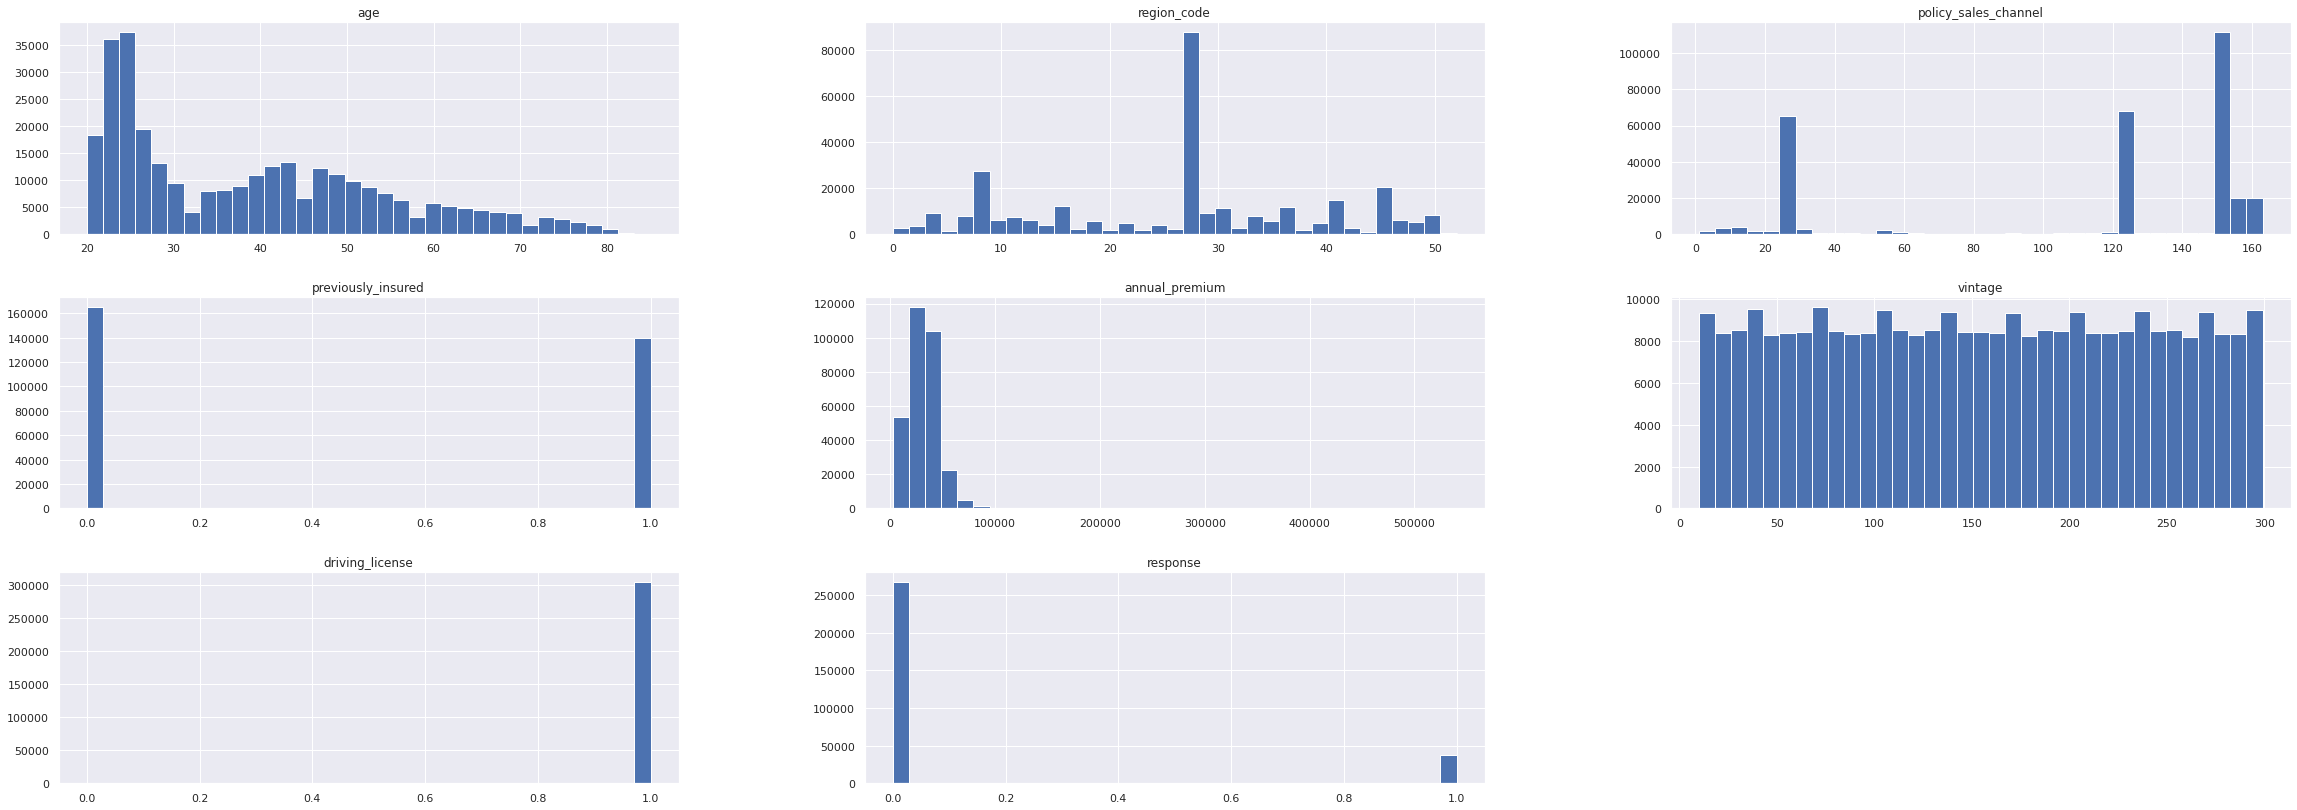

In [66]:
train_set.drop(columns=['id']).hist(figsize=(40,14), bins=35);

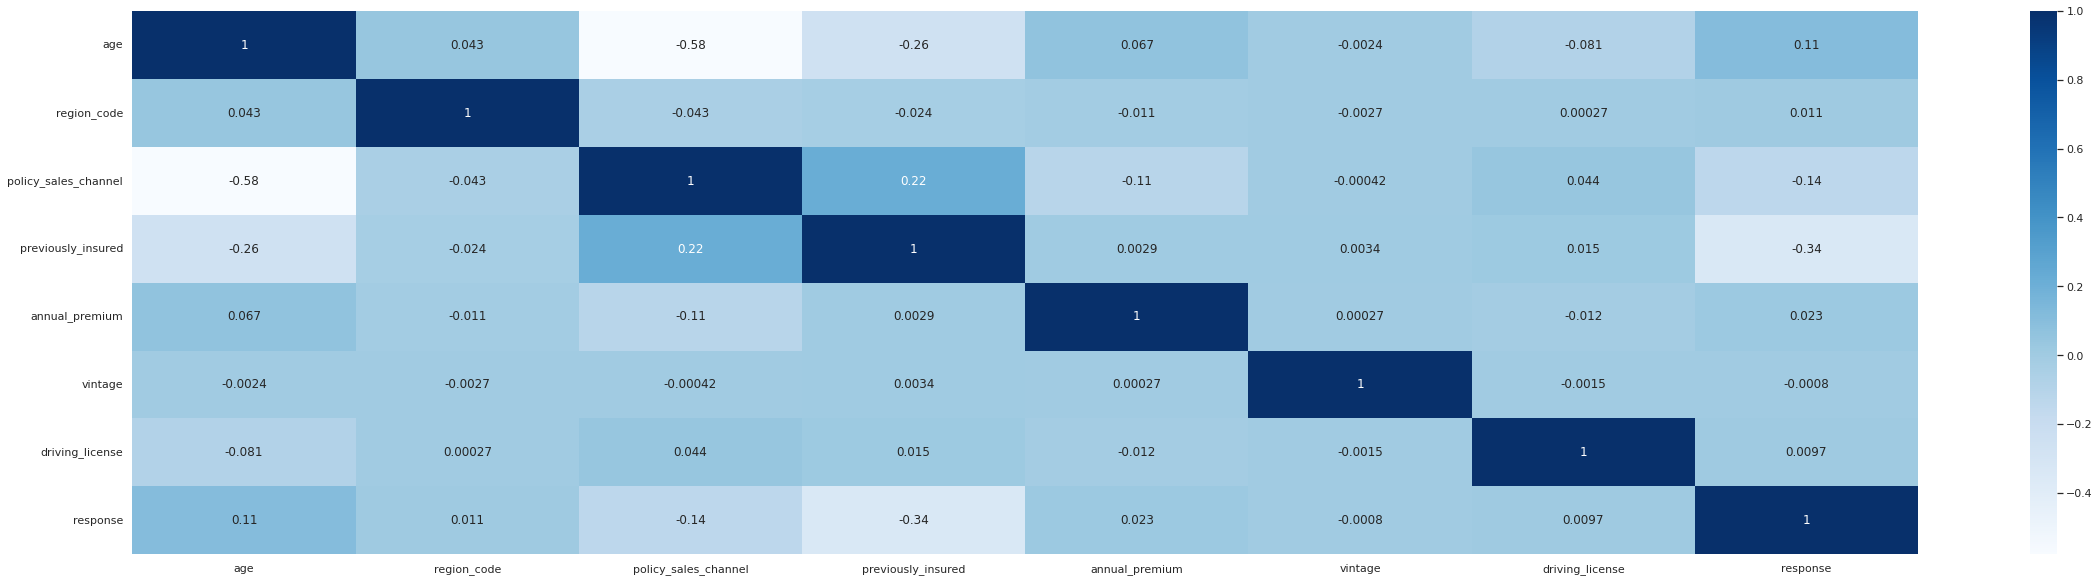

In [67]:
sns.heatmap(
    train_set.drop(columns=['id']).corr(method='pearson'), annot=True,
    cmap = 'Blues'
);

### Age vs Anual Premium

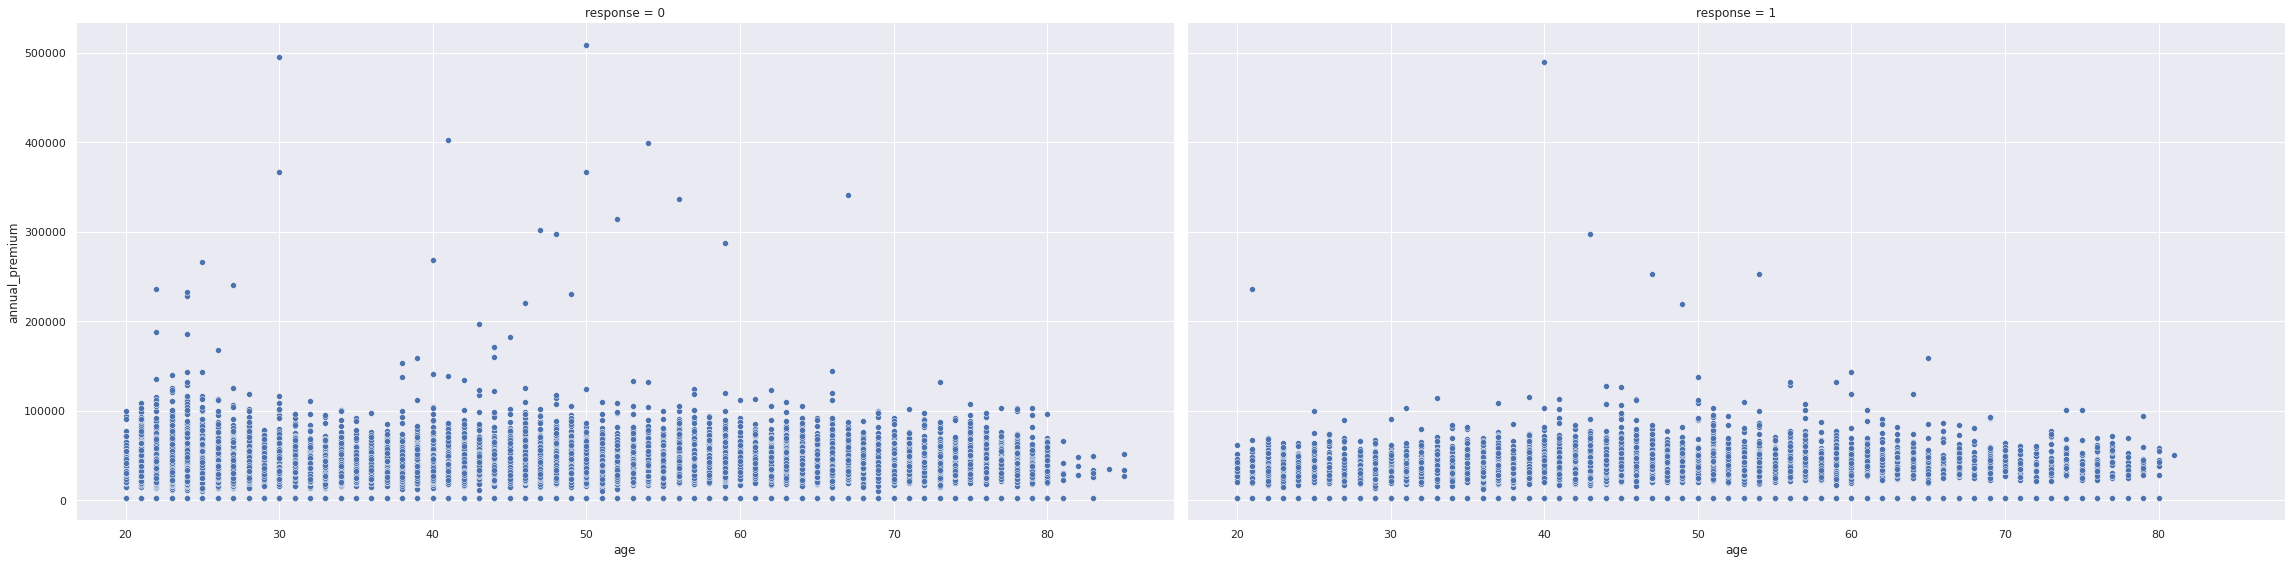

In [68]:
sns.relplot(
    data=test_set, x='age', y='annual_premium', col='response',
    kind='scatter', height=8, aspect = 2
);


### Target Variable

The amount of interestred customers is 13.90% of the total database.


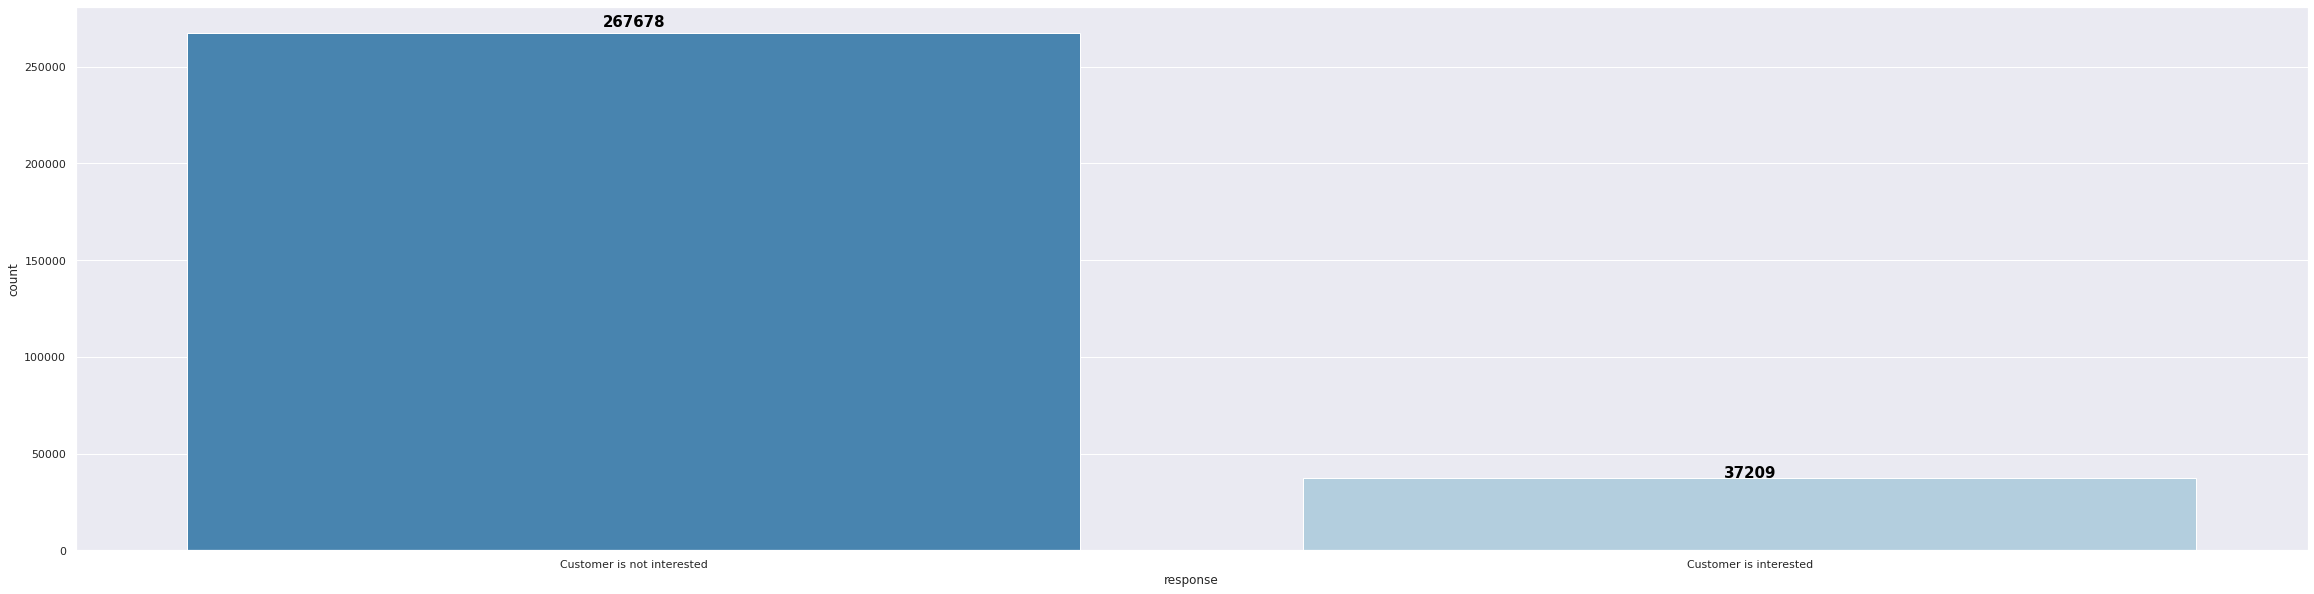

In [69]:
ax = sns.countplot(
    train_set.response, 
    palette='Blues_r'
);
ax.set_xticklabels( [ "Customer is not interested", "Customer is interested" ] );
for i in ax.patches:
    ax.annotate(
        #Texto a ser plotado
        round(i.get_height()),
        #Posição horizontal
        (i.get_x() + i.get_width() /2, i.get_height() + i.get_height() /80 ),
        ha='center' ,   
        color='black',
        weight='bold',
        fontsize=15
    );

print('The amount of interestred customers is {:.2f}% of the total database.'.format( train_set[train_set.response == 1].id.count() *100 / train_set[train_set.response == 0].id.count() ) )

### 6.1 Hypotheses List creation

#### Mind Map

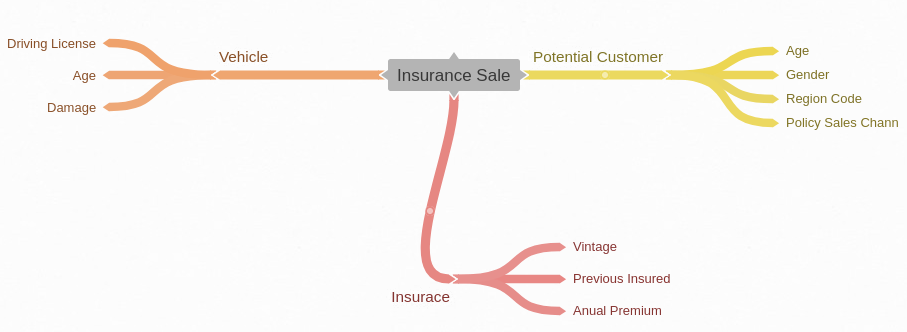

In [70]:
Image('image/MindMap.png', height=500)

#### Hypotheses of correlation list

- Gender             | Response
- Damage             | Response
- Previously Insured | Response
- Vehicle age        | Response

#### Gender x Response

'Nota-se que em ambos os casos de resposta, há mais pessoas do sexo masculino não demonstrando correlação forte entre "gender | response"'

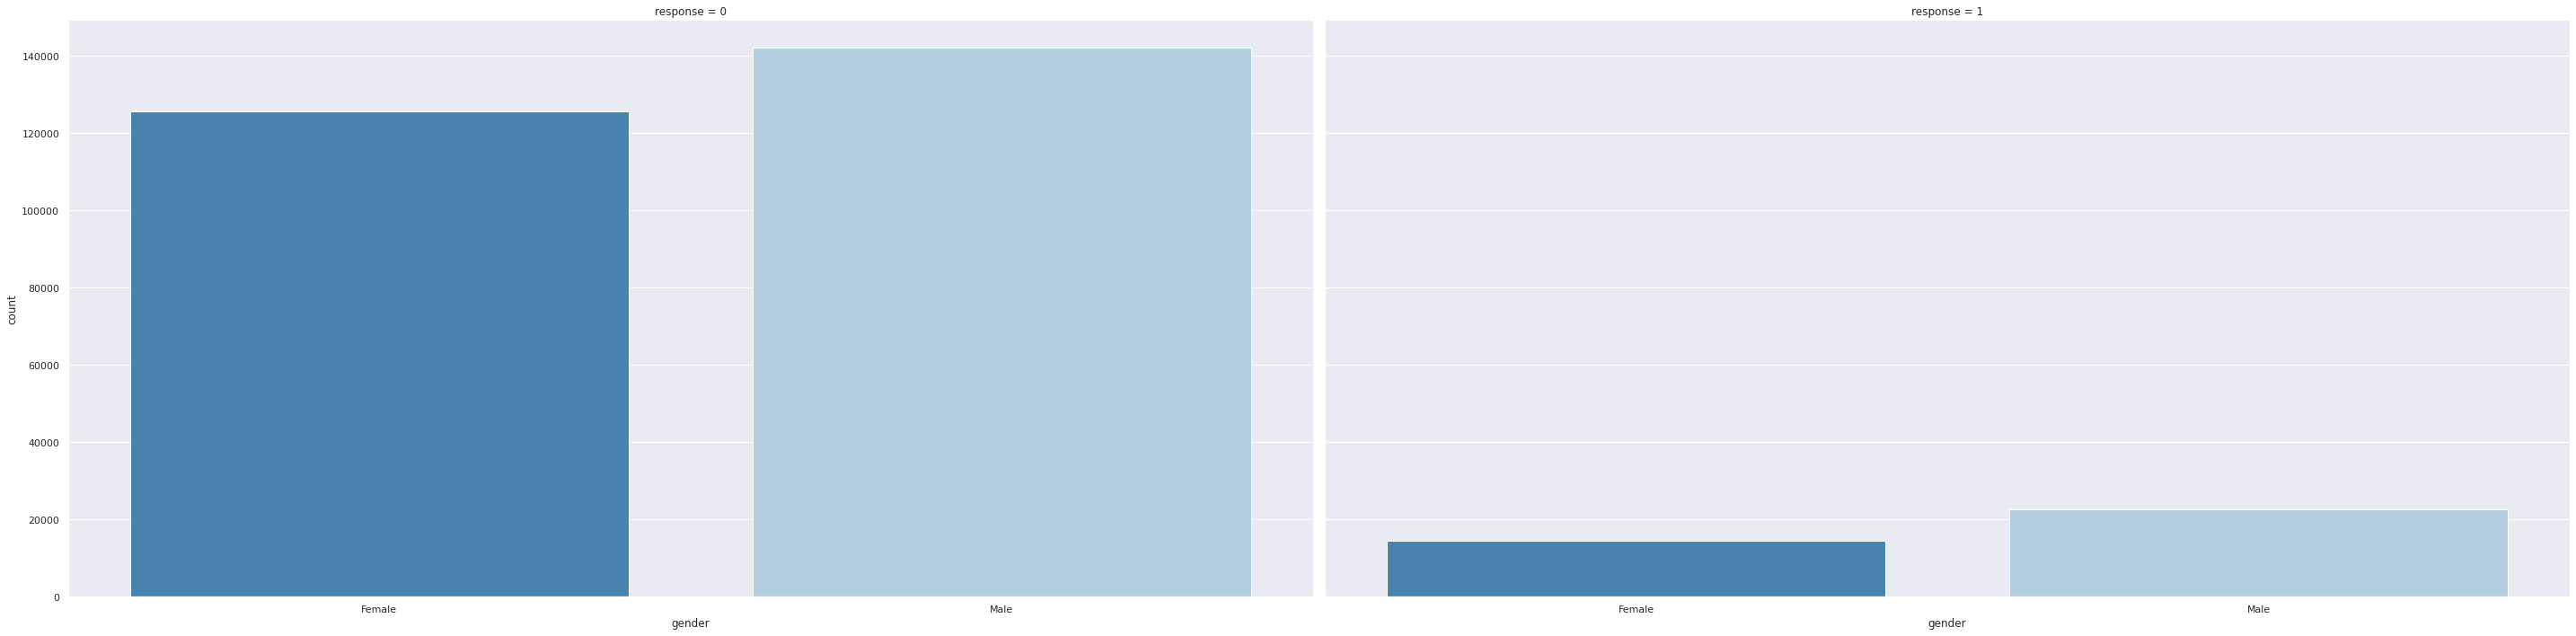

In [71]:
df_aux = train_set.groupby( ['gender', 'response'] )[[ 'id' ]].count().rename( columns = {'id' : 'count'} ).reset_index()
ax = sns.catplot(
    data = df_aux, x='gender', y='count', col = 'response',
    kind = 'bar', height=10, aspect = 2, 
    palette = 'Blues_r'
);

display('Nota-se que em ambos os casos de resposta, há mais pessoas do sexo masculino não demonstrando correlação forte entre "gender | response"')

#### Damage x Response

'Nota-se, que a quantidade quase absoluta de pessoas que demonstraram interesse em seguros, já tiveram seus carros "danificados" no passado, demonstrando fortíssima correlação entre as variáveis'

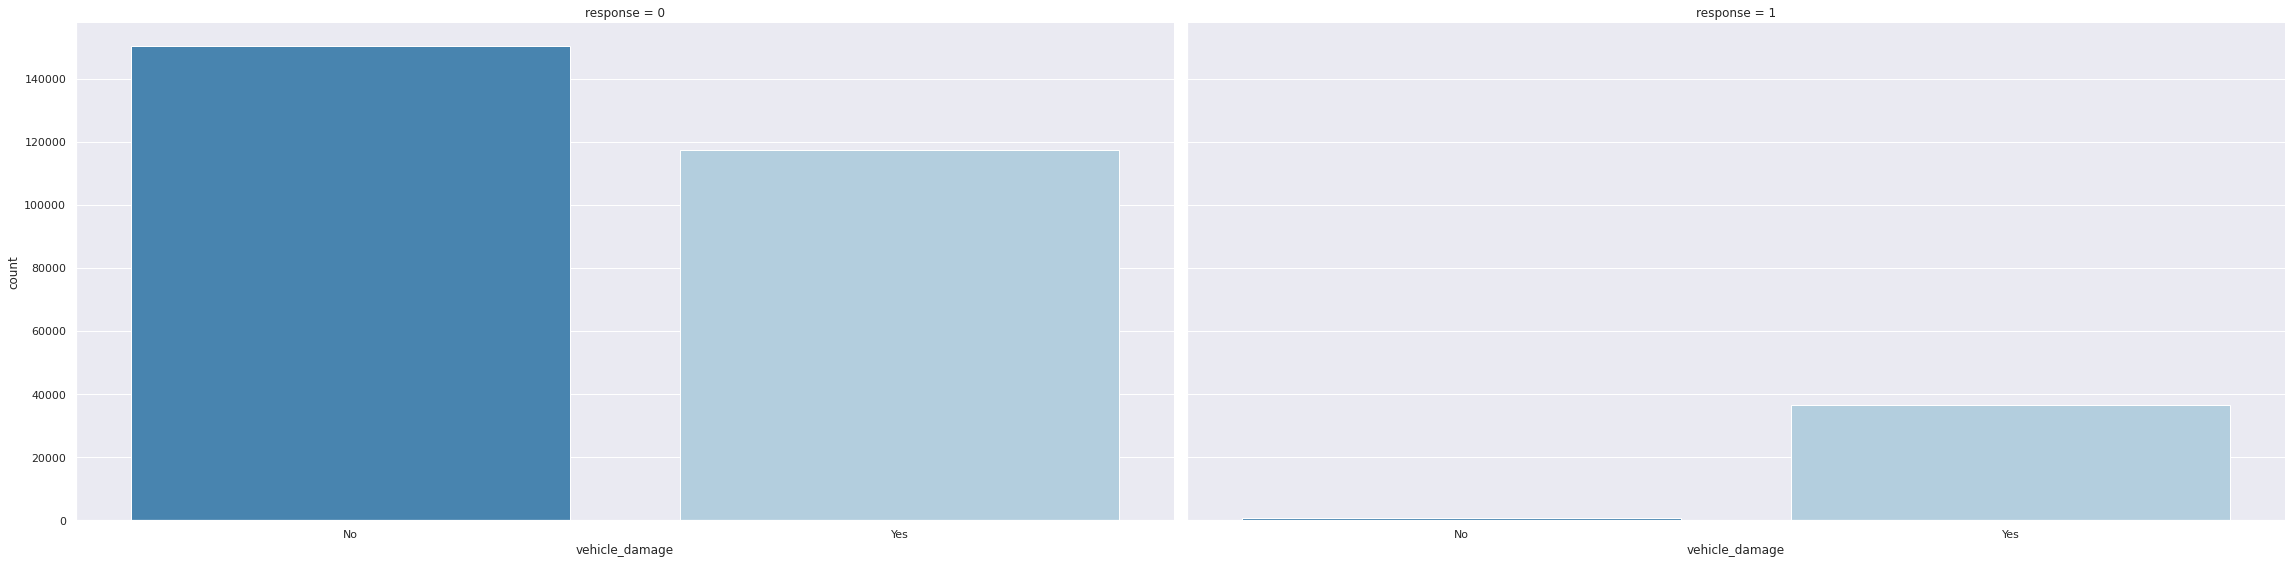

In [72]:
df_aux=train_set.groupby(['vehicle_damage','response'])[['id']].count().rename(columns={'id':'count'}).reset_index()
ax = sns.catplot(
    data = df_aux, 
    x = 'vehicle_damage', y = 'count', col = 'response',
    kind = 'bar', 
    height = 8, aspect = 2,
    palette = 'Blues_r'
);

display('Nota-se, que a quantidade quase absoluta de pessoas que demonstraram interesse em seguros, já tiveram seus carros "danificados" no passado, demonstrando fortíssima correlação entre as variáveis')

#### Previously Insured x Response

'Nota-se que em quase totalidade, os donos de veículos não assegurados demonstram maior interesse na proposta, demonstrando fortíssima correlação (negativa) entre as variáveis '

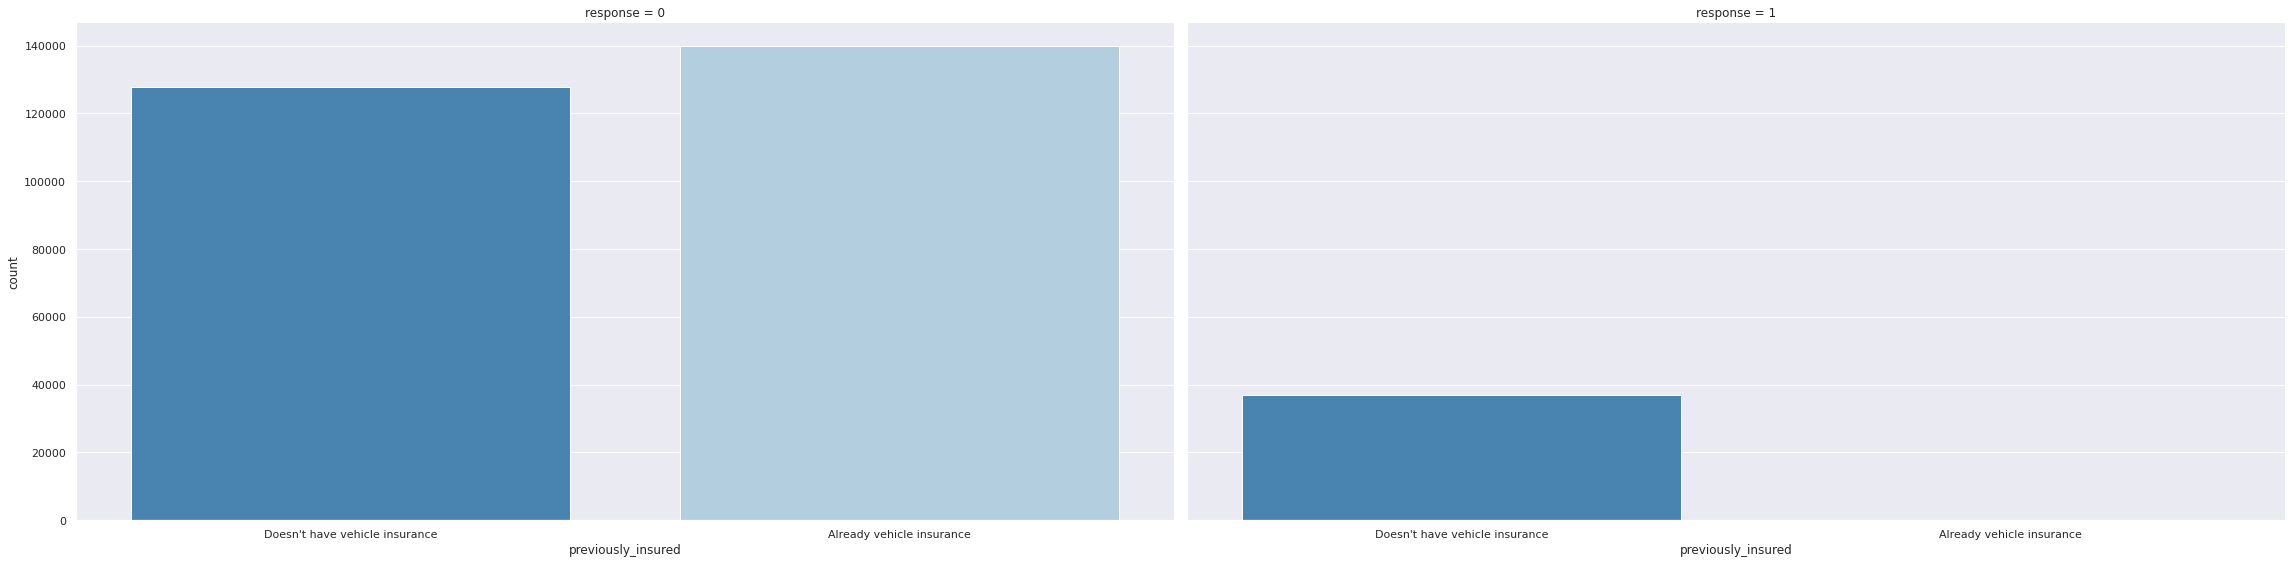

In [77]:
df_aux = train_set.groupby( ['previously_insured', 'response'] )[['id']].count().rename(columns={'id':'count'}).reset_index()
df_aux

ax = sns.catplot(
    data = df_aux, 
    x='previously_insured', y='count', col='response',
    kind = 'bar', height = 8, aspect = 2,
    palette='Blues_r'   
);
ax.set_xticklabels(["Doesn't have vehicle insurance", "Already vehicle insurance"]);
display('Nota-se que em quase totalidade, os donos de veículos não assegurados demonstram maior interesse na proposta, demonstrando fortíssima correlação (negativa) entre as variáveis ')

#### Vehicle age x Response

In [85]:
train_set.vehicle_age.unique()

array(['< 1 Year', '1-2 Year', '> 2 Years'], dtype=object)

'Apresar de seguir uma tendência geral dos dados, nota-se que donos de carros entre 1~2 anos, tendem a se interessar mais pela proposta.'

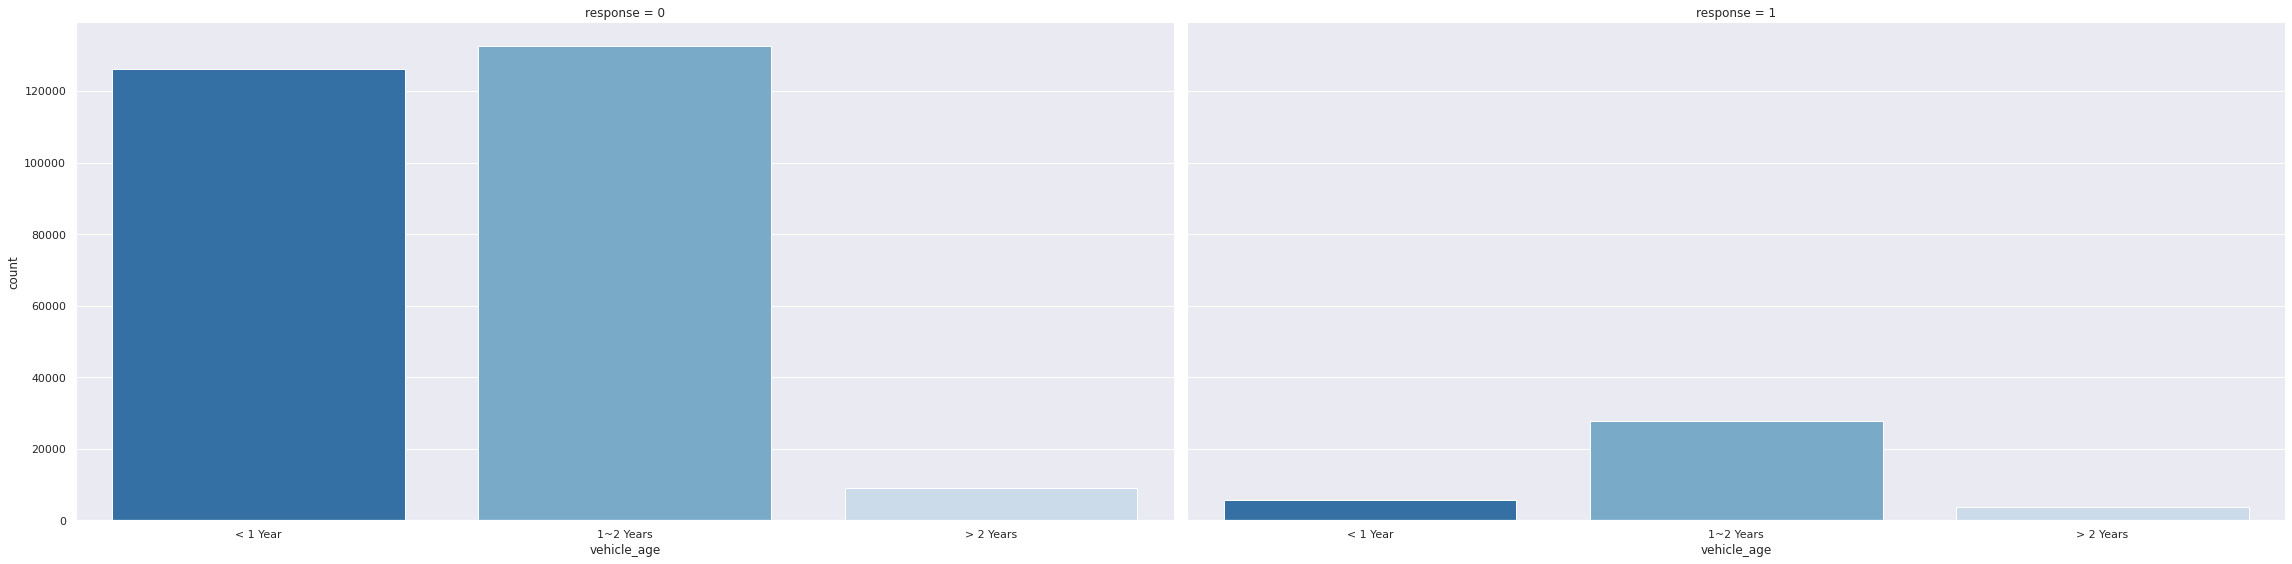

In [88]:
df_aux = train_set.groupby( ['vehicle_age', 'response'] )[['id']].count().rename( columns={'id':'count'} ).reset_index()

ax = sns.catplot(
    data    = df_aux,
    x       = 'vehicle_age', y = 'count', col = 'response', 
    height  = 8, aspect = 2, kind='bar',
    palette = 'Blues_r',
    order=['< 1 Year', '1-2 Year', '> 2 Years']
);
ax.set_xticklabels( ['< 1 Year', '1~2 Years', '> 2 Years'] );
display("Apresar de seguir uma tendência geral dos dados, nota-se que donos de carros entre 1~2 anos, tendem a se interessar mais pela proposta.")

### 6.2 Analysis of features isolated

#### Annual Premium Distribuition

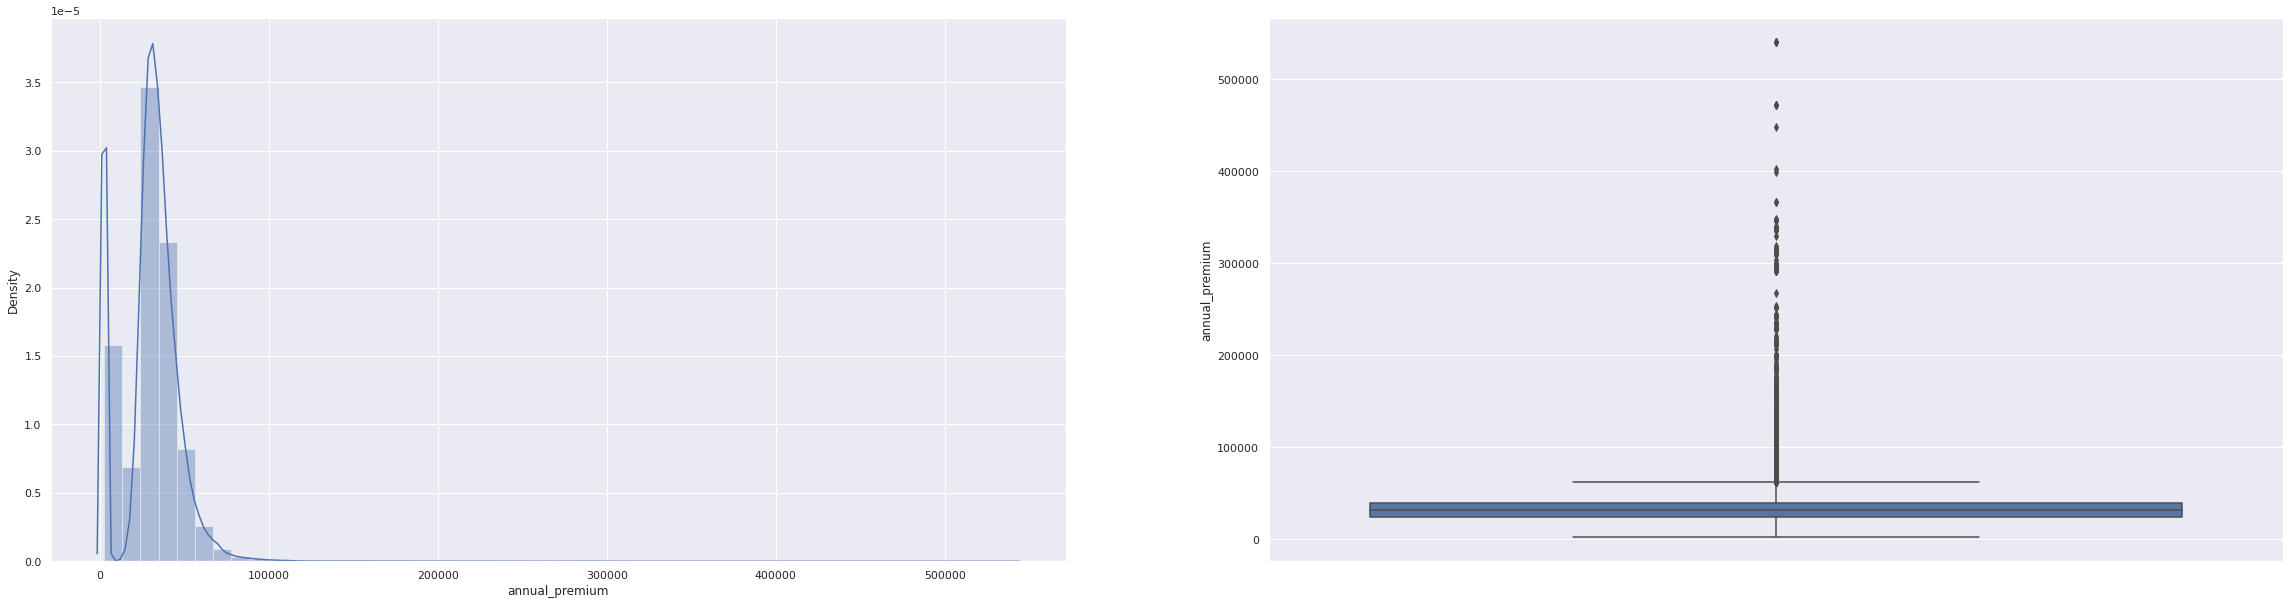

In [75]:
spec = gridspec.GridSpec(1,2)

plt.subplot(spec[0,0])
ax1 = sns.distplot(
    train_set.annual_premium
);

plt.subplot(spec[0,1])
ax = sns.boxplot(
    data=train_set, y='annual_premium'
);

## 7. Data Encoding | Normalization 

### One Hot Encoder

In [139]:
train_set = data_hotencoding(train_set, 'gender')
train_set = data_hotencoding(train_set, 'vehicle_damage')

### Vehicle_age transform

In [167]:
train_set['vehicle_age'] = train_set.vehicle_age.apply( lambda x: 0 if x == '< 1 Year' else 1 if x == '1-2 Year' else 3 )

In [168]:
train_set

,id,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,response,gender_0,gender_1,vehicle_damage_0,vehicle_damage_1
0,50274,21,37.0,160.0,0,28404.0,142,1,0,0,0.0,1.0,0.0,1.0
1,66126,57,28.0,26.0,0,48283.0,298,1,3,0,0.0,1.0,0.0,1.0
2,176690,59,28.0,26.0,0,41549.0,121,1,1,0,1.0,0.0,0.0,1.0
3,207390,23,41.0,124.0,0,22126.0,184,1,0,1,1.0,0.0,0.0,1.0
4,205816,23,28.0,152.0,0,34036.0,162,1,0,0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304882,140718,65,28.0,124.0,0,44182.0,262,1,1,0,0.0,1.0,0.0,1.0
304883,10981,22,6.0,152.0,1,25844.0,35,1,0,0,1.0,0.0,1.0,0.0
304884,275775,20,6.0,160.0,1,15993.0,234,1,0,0,1.0,0.0,1.0,0.0
304885,339151,42,34.0,124.0,1,21355.0,277,1,1,0,0.0,1.0,1.0,0.0


## 7. 

## 7. 